In [1]:
# Local utilities
from util import *
environment_check()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

CUDA is available
Tensor on GPU: tensor([1., 2., 3.], device='cuda:0')

PyTorch3D is using CUDA


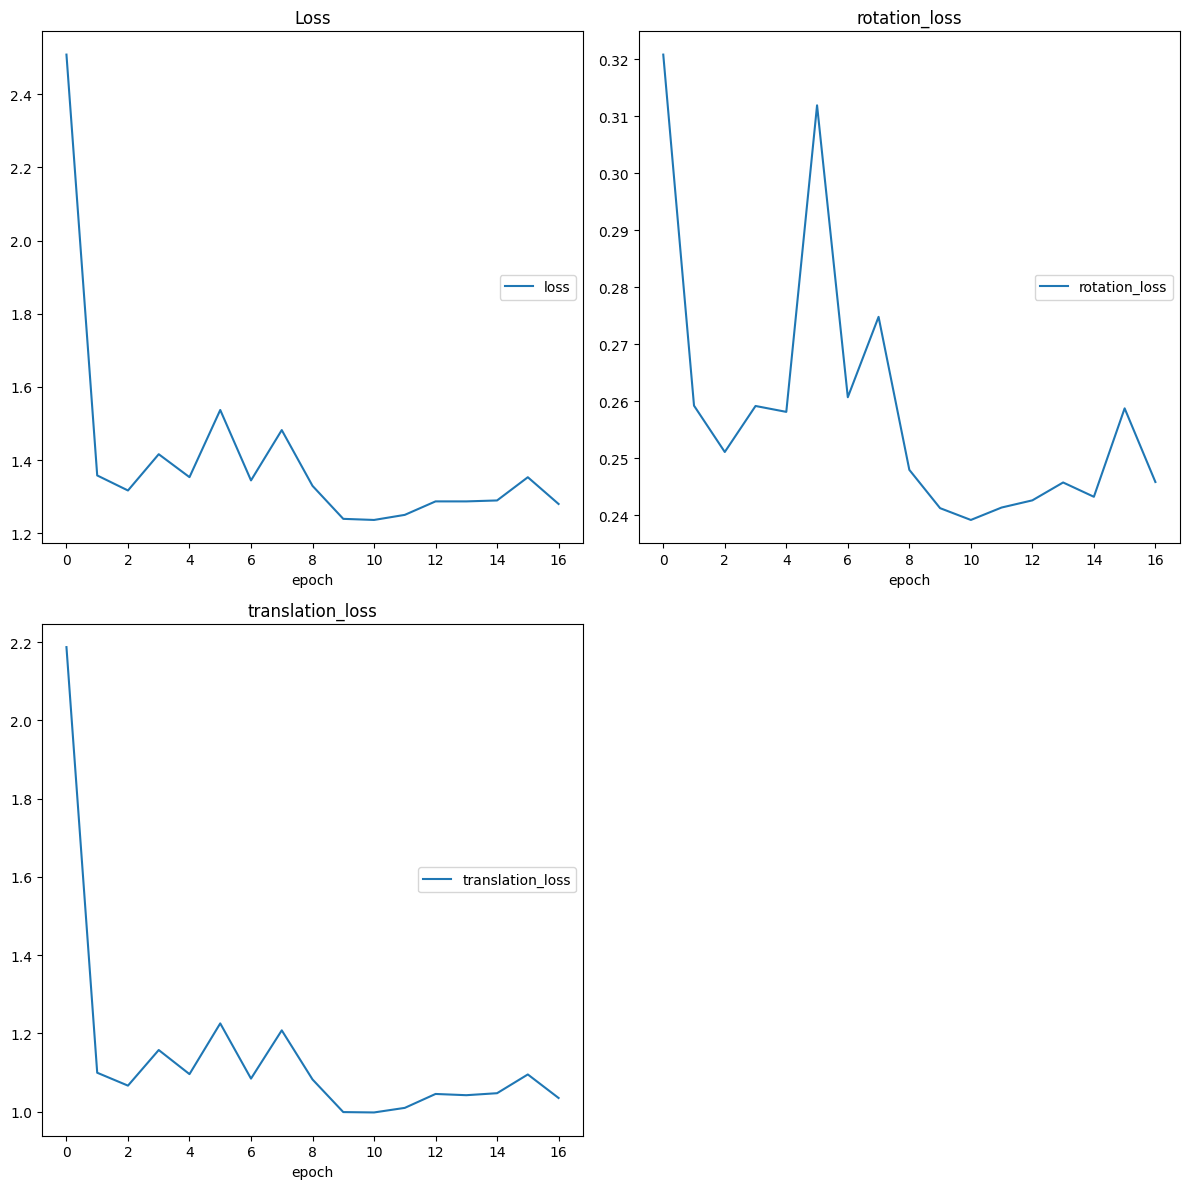

Loss
	loss             	 (min:    1.237, max:    2.508, cur:    1.280)
rotation_loss
	rotation_loss    	 (min:    0.239, max:    0.321, cur:    0.246)
translation_loss
	translation_loss 	 (min:    0.998, max:    2.187, cur:    1.035)


KeyboardInterrupt: 

In [2]:
import torch
import json
from PIL import Image
from torchvision import transforms
from torch.utils.data import DataLoader
from torch import nn
from torchvision.models import vit_b_16, ViT_B_16_Weights
from torch.optim import Adam
import logging
import torch
import json
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
import logging

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

class PoseRefinementDataset(torch.utils.data.Dataset):
    def __init__(self, data_json_filepath):
        with open(data_json_filepath, 'r') as f:
            self.data_json = json.load(f)
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        logging.info("Dataset loaded with {} samples".format(len(self.data_json)))

    def __len__(self):
        return len(self.data_json)

    def __getitem__(self, idx):
        entry = self.data_json[idx]
        image = Image.open(entry['silhouette_path']).convert('L').convert('RGB')
        image = self.transform(image)
        rt_matrix = torch.tensor(entry['RT'], dtype=torch.float32)
        if rt_matrix.numel() == 16:
            rt_matrix = rt_matrix.view(4, 4)[:-1]  # Assuming the last row is [0, 0, 0, 1] and can be discarded
        else:
            rt_matrix = rt_matrix.view(3, 4)  # Normal case
        logging.debug(f"Image and RT matrix loaded for index {idx}")
        return image, rt_matrix
    
    def show_sample(self, idx):
        image, rt_matrix = self.__getitem__(idx)
        image_np = image.numpy().transpose((1, 2, 0))
        image_np = np.clip(image_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]), 0, 1)
        plt.imshow(image_np)
        plt.title(f"Sample {idx} - RT Matrix: \n{rt_matrix.numpy()}")
        plt.show()    

# Example usage to display a sample from the dataset
dataset = PoseRefinementDataset("./pose_refine_dataset/dataset_info.json")
dataset.show_sample(0)  # Display the first sample
        
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import vit_b_32, ViT_B_32_Weights
import logging

class ViTImageToRTNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        # CNN Layer to be added before the ViT model
        self.cnn_layer = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        
        # ViT model setup, changed to use vit_b_32 with the default weights
        self.vit = vit_b_32(weights=ViT_B_32_Weights.DEFAULT)  # Changed to vit_b_32
        self.vit.heads = nn.Identity()  # Remove the classifier head
        
        # Regression layers
        self.rotation_regressor = nn.Linear(768, 9)  # Assuming 768-dimensional output from ViT model
        self.translation_regressor = nn.Linear(768, 3)  # Assuming the same for consistency

        logging.info("ViT model initialized with removed classifier head, regressors added, and preceding CNN layer")

    def forward(self, x):
        # Pass input through CNN layer first
        x = self.cnn_layer(x)
        
        # Pass the output of CNN to ViT model
        features = self.vit(x)
        cls_token = features
        
        # Compute rotation and translation
        rotation = self.rotation_regressor(cls_token).view(-1, 3, 3)
        translation = self.translation_regressor(cls_token).view(-1, 3, 1)
        
        # Concatenate to form the RT matrix
        rt_matrix = torch.cat((rotation, translation), dim=2)
        logging.debug("Model forward pass completed")
        return rt_matrix


from livelossplot import PlotLosses
def train_model(dataset, epochs, batch_size, learning_rate, model_save_path):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    model = ViTImageToRTNetwork().to(device)
    optimizer = Adam(model.parameters(), lr=learning_rate)

    liveloss = PlotLosses()
    rotation_loss_fn = nn.MSELoss()
    translation_loss_fn = nn.MSELoss()

    for epoch in range(epochs):
        logs = {}
        model.train()
        total_loss, total_rotation_loss, total_translation_loss = 0, 0, 0
        for images, rt_matrices in loader:
            images = images.to(device)
            rt_matrices = rt_matrices.to(device)
            optimizer.zero_grad()

            outputs = model(images)
            pred_rotation = outputs[:, :, :3]
            pred_translation = outputs[:, :, 3:]

            true_rotation = rt_matrices[:, :, :3]
            true_translation = rt_matrices[:, :, 3:]

            loss_rotation = rotation_loss_fn(pred_rotation, true_rotation)
            loss_translation = translation_loss_fn(pred_translation, true_translation)

            loss = loss_rotation + loss_translation
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            total_rotation_loss += loss_rotation.item()
            total_translation_loss += loss_translation.item()

        logs['loss'] = total_loss / len(loader)
        logs['rotation_loss'] = total_rotation_loss / len(loader)
        logs['translation_loss'] = total_translation_loss / len(loader)
        liveloss.update(logs)
        liveloss.send()

        # Save checkpoint after each epoch
        torch.save(model.state_dict(), model_save_path.format(epoch))

    # No need for liveloss.close(), so it's removed.

    # Save final model
    torch.save(model.state_dict(), model_save_path.format('final'))


def evaluate_model(dataset, batch_size=32):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = ViTImageToRTNetwork().to(device)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    criterion = nn.MSELoss()
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for images, rt_matrices in loader:
            images, rt_matrices = images.to(device), rt_matrices.to(device)
            outputs = model(images)
            loss = criterion(outputs, rt_matrices)
            total_loss += loss.item()
    logging.info(f"Validation Loss: {total_loss / len(loader)}")
# Example usage
dataset = PoseRefinementDataset("./pose_refine_dataset/dataset_info.json")
model_save_path = "./pose_refine_dataset/pose_refine_model_epoch_{}.pth"  # Path where you want to save the model weights
train_model(dataset, epochs=100, batch_size=8, learning_rate=0.001, model_save_path=model_save_path)

 


In [ ]:
dataset_path = "./pose_refine_dataset_e/dataset_info.json"
dataset_e = PoseRefinementDataset(dataset_path)
evaluate_model(dataset_e, batch_size=4)